In [2]:
## Importing libraries 
import json
import zipfile
import os 
import librosa
import torch
import torch.nn as nn
import copy
import pytorch_lightning as pl
import time 
import torchaudio
import noisereduce as nr
from scipy.io import wavfile

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [69]:
train_speaker_id = 178 ## TO BE CHANGED ## 
val_speaker_id = 44 ## TO BE CHANGED ## 
data_dir = '/home/dgxuser/Desktop/kailin/CHANNEL0/WAVE'
script_dir = '/home/dgxuser/Desktop/kailin/CHANNEL0/SCRIPT/'
train_manifest_path = '/home/dgxuser/Desktop/kailin/CHANNEL0/manifest_S' + str(train_speaker_id) + '.json'
val_manifest_path = '/home/dgxuser/Desktop/kailin/CHANNEL0/manifest_S' + str(val_speaker_id) + '.json'
#train_speakers = ['0091', '0124', '0135', '0148', '0173', '0178', '0190', '0194', '0208', '0218', '0245', '0276', '0289', '0308', '0314', '0317', '0329', '0330', '0337', '0349', '0379', '0397', '0432', '0443', '0451', '0462', '0488', '0489', '0490', '0501', '0537', '0543', '0557', '0591', '0592', '0603', '0620', '0627', '0634', '0658', '0659', '0675', '0743', '0762', '0763', '0766', '0778', '0780', '0785', '0790', '0791', '0792', '0798', '0799', '0812', '0831', '0872', '0881', '1058', '1064', '1444']
#val_speakers = ['0044', '0047', '0056', '0066', '0074']
train_speakers = ['0178'] ## TO BE CHANGED ## 
val_speakers = ['0044'] ## TO BE CHANGED ## 

## Function to build a manifest
def build_manifest(manifest_path, speakers):
  count = 0
  with open(manifest_path, 'w') as fout: 
    for i in speakers: 
      path_unzipped = data_dir + '/SPEAKER' + i
      if not os.path.exists(path_unzipped):
        path = data_dir + '/SPEAKER' + i + '.zip'
        zip_ref = zipfile.ZipFile(path, 'r')
        zip_ref.extractall(path=data_dir)
      n = 0 
      wav_folder = data_dir + '/SPEAKER' + i + '/SESSION'
      while os.path.exists(wav_folder + str(n)):
        files = []
        
        for filename in os.listdir(wav_folder + str(n)):
          audio_path = os.path.join(wav_folder + str(n), filename)
          y, sr = torchaudio.load(audio_path)
          y = y.mean(dim=0) # if there are multiple channels, average them to single channel
          if sr != 22050:
            resampler = torchaudio.transforms.Resample(sr, 22050)
            y_resampled = resampler(y)
          torchaudio.save(audio_path[:-4] + '_resampled.wav', y.unsqueeze(0), sr)

          rate, data = wavfile.read(audio_path[:-4] + '_resampled.wav')
          # perform noise reduction
          reduced_noise = nr.reduce_noise(y=data, sr=rate)
          wavfile.write(audio_path[:-4] + '_clean.wav', rate, reduced_noise)
          files.append(filename[:-4] + '_clean.wav')
            
        files = sorted(files)
        script_path = script_dir + filename[:6] + '.TXT'
        with open(script_path, encoding = 'utf-8') as script:
          for filename in files:
            #getting transcript 
            script.readline()
            line = script.readline().strip()
            words = line.split()
            edited_words = []
            for word in words:
              if (word[-1] != '>') and (word != '**'):
                edited_words.append(word.lower())
            transcript_line = ""
            for word in edited_words: 
              transcript_line = transcript_line + word + " "
            transcript_line = transcript_line[:-1]
            #getting audio file
            audio_path = os.path.join(wav_folder + str(n), filename)
            duration = librosa.core.get_duration(filename=audio_path)
            # Write the metadata to the manifest
            metadata = {
                "audio_filepath": audio_path,
                "text": transcript_line,
                "duration": duration,
                "text_no_preprocessing": transcript_line, 
                "text_normalized": transcript_line
            }
            json.dump(metadata, fout)
            fout.write('\n')
        n = n+1
        
build_manifest(train_manifest_path, train_speakers)
#build_manifest(val_manifest_path, val_speakers)

In [4]:
#home_path = '/home/dgxuser/Desktop/kailin'
home_path = '/home/dgxuser'
print(home_path)

/home/dgxuser


In [5]:
import os
import json

import torch
import IPython.display as ipd
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

from nemo.collections.tts.models import FastPitchModel
FastPitchModel.from_pretrained("tts_en_fastpitch")

from pathlib import Path
nemo_files = [p for p in Path(f"{home_path}/.cache/torch/NeMo/").glob("**/tts_en_fastpitch_align.nemo")]
print(f"Copying {nemo_files[0]} to ./")
Path("./tts_en_fastpitch_align.nemo").write_bytes(nemo_files[0].read_bytes())

[NeMo W 2022-06-27 10:35:19 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2022-06-27 10:35:19 experimental:27] Module <class 'nemo.collections.nlp.data.language_modeling.megatron.megatron_batch_samplers.MegatronPretrainingRandomBatchSampler'> is experimental, not ready for production and is not fully supported. Use at your own risk.


[NeMo I 2022-06-27 10:35:20 cloud:56] Found existing object /home/dgxuser/.cache/torch/NeMo/NeMo_1.8.2/tts_en_fastpitch_align/26d7e09971f1d611e24df90c7a9d9b38/tts_en_fastpitch_align.nemo.
[NeMo I 2022-06-27 10:35:20 cloud:62] Re-using file from: /home/dgxuser/.cache/torch/NeMo/NeMo_1.8.2/tts_en_fastpitch_align/26d7e09971f1d611e24df90c7a9d9b38/tts_en_fastpitch_align.nemo
[NeMo I 2022-06-27 10:35:20 common:747] Instantiating model from pre-trained checkpoint
[NeMo I 2022-06-27 10:35:21 tokenize_and_classify:88] Creating ClassifyFst grammars.


[NeMo W 2022-06-27 10:35:27 g2ps:84] apply_to_oov_word=None, it means that some of words will remain unchanged if they are not handled by one of rule in self.parse_one_word(). It is useful when you use tokenizer with set of phonemes and chars together, otherwise it can be not.
[NeMo W 2022-06-27 10:35:27 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /ws/LJSpeech/nvidia_ljspeech_train_clean_ngc.json
      sample_rate: 22050
      sup_data_path: /raid/LJSpeech/supplementary
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null
      min_duration: 0.1
      ignore_file: nu

[NeMo I 2022-06-27 10:35:27 features:259] PADDING: 1
[NeMo I 2022-06-27 10:35:27 features:276] STFT using torch
[NeMo I 2022-06-27 10:35:31 save_restore_connector:209] Model FastPitchModel was successfully restored from /home/dgxuser/.cache/torch/NeMo/NeMo_1.8.2/tts_en_fastpitch_align/26d7e09971f1d611e24df90c7a9d9b38/tts_en_fastpitch_align.nemo.
Copying /home/dgxuser/.cache/torch/NeMo/NeMo_1.8.2/tts_en_fastpitch_align/26d7e09971f1d611e24df90c7a9d9b38/tts_en_fastpitch_align.nemo to ./


187023360

In [6]:
BRANCH = 'main'

!wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/fastpitch_finetune.py

!mkdir -p conf \
&& cd conf \
&& wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/conf/fastpitch_align_v1.05.yaml \
&& cd ..

--2022-06-27 10:35:32--  https://raw.githubusercontent.com/nvidia/NeMo/main/examples/tts/fastpitch_finetune.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1751 (1.7K) [text/plain]
Saving to: ‘fastpitch_finetune.py.1’

fastpitch_finetune. 100%[===================>]   1.71K  --.-KB/s    in 0s      

2022-06-27 10:35:37 (23.4 MB/s) - ‘fastpitch_finetune.py.1’ saved [1751/1751]

--2022-06-27 10:35:37--  https://raw.githubusercontent.com/nvidia/NeMo/main/examples/tts/conf/fastpitch_align_v1.05.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8003::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP req

In [7]:
# additional files
!mkdir -p tts_dataset_files && cd tts_dataset_files \
&& wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/scripts/tts_dataset_files/cmudict-0.7b_nv22.01 \
&& wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/scripts/tts_dataset_files/heteronyms-030921 \
&& wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/nemo_text_processing/text_normalization/en/data/whitelist/lj_speech.tsv \
&& cd ..

--2022-06-27 10:35:38--  https://raw.githubusercontent.com/NVIDIA/NeMo/main/scripts/tts_dataset_files/cmudict-0.7b_nv22.01
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3721964 (3.5M) [text/plain]
Saving to: ‘cmudict-0.7b_nv22.01.1’

cmudict-0.7b_nv22.0 100%[===================>]   3.55M   665KB/s    in 6.9s    

2022-06-27 10:35:47 (527 KB/s) - ‘cmudict-0.7b_nv22.01.1’ saved [3721964/3721964]

--2022-06-27 10:35:47--  https://raw.githubusercontent.com/NVIDIA/NeMo/main/scripts/tts_dataset_files/heteronyms-030921
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... co

In [ ]:
# Using synthesised spectrograms 
import json
import numpy as np
import torch
import soundfile as sf

from pathlib import Path

from nemo.collections.tts.torch.helpers import BetaBinomialInterpolator


def load_wav(audio_file, target_sr=None):
    with sf.SoundFile(audio_file, 'r') as f:
        samples = f.read(dtype='float32')
        sample_rate = f.samplerate
        if target_sr is not None and target_sr != sample_rate:
            samples = librosa.core.resample(samples, orig_sr=sample_rate, target_sr=target_sr)
    return samples.transpose()

# Get records from the training manifest
records = []
with open(train_manifest_path, "r") as f:
    for i, line in enumerate(f):
        records.append(json.loads(line))

beta_binomial_interpolator = BetaBinomialInterpolator()
spec_model.eval()

device = spec_model.device

save_dir = Path('/home/dgxuser/Desktop/kailin/melSpect')
save_dir.mkdir(exist_ok=True, parents=True)

# Generate a spectrograms (we need to use ground truth alignment for correct matching between audio and mels)
for i, r in enumerate(records):
    audio = load_wav(r["audio_filepath"])
    audio = torch.from_numpy(audio).unsqueeze(0).to(device)
    audio_len = torch.tensor(audio.shape[1], dtype=torch.long, device=device).unsqueeze(0)
    
    # Again, our finetuned FastPitch model doesn't use multiple speakers,
    # but we keep the code to support it here for reference
    if spec_model.fastpitch.speaker_emb is not None and "speaker" in r:
        speaker = torch.tensor([r['speaker']]).to(device)
    else:
        speaker = None
    
    with torch.no_grad():
        if "normalized_text" in r:
            text = spec_model.parse(r["normalized_text"], normalize=False)
        else:
            text = spec_model.parse(r['text'])
        
        text_len = torch.tensor(text.shape[-1], dtype=torch.long, device=device).unsqueeze(0)
    
        spect, spect_len = spec_model.preprocessor(input_signal=audio, length=audio_len)

        # Generate attention prior and spectrogram inputs for HiFi-GAN
        attn_prior = torch.from_numpy(
          beta_binomial_interpolator(spect_len.item(), text_len.item())
        ).unsqueeze(0).to(text.device)
            
        spectrogram = spec_model.forward(
          text=text, 
          input_lens=text_len, 
          spec=spect, 
          mel_lens=spect_len, 
          attn_prior=attn_prior,
          speaker=speaker,
        )[0]
        
        save_path = save_dir / f"mel_{i}.npy"
        np.save(save_path, spectrogram[0].to('cpu').numpy())
        r["mel_filepath"] = str(save_path)

hifigan_manifest_path = '/home/dgxuser/Desktop/kailin/CHANNEL0/melSpect_train.json'
with open(hifigan_manifest_path, "w") as f:
    for r in records:
        f.write(json.dumps(r) + '\n')

In [ ]:
# Get records from the validation manifest
records = []
with open(val_manifest_path, "r") as f:
    for i, line in enumerate(f):
        records.append(json.loads(line))

beta_binomial_interpolator = BetaBinomialInterpolator()
spec_model.eval()

device = spec_model.device

save_dir = Path('/home/dgxuser/Desktop/kailin/melSpectVal')
save_dir.mkdir(exist_ok=True, parents=True)

# Generate a spectrograms (we need to use ground truth alignment for correct matching between audio and mels)
for i, r in enumerate(records):
    audio = load_wav(r["audio_filepath"])
    audio = torch.from_numpy(audio).unsqueeze(0).to(device)
    audio_len = torch.tensor(audio.shape[1], dtype=torch.long, device=device).unsqueeze(0)
    
    # Again, our finetuned FastPitch model doesn't use multiple speakers,
    # but we keep the code to support it here for reference
    if spec_model.fastpitch.speaker_emb is not None and "speaker" in r:
        speaker = torch.tensor([r['speaker']]).to(device)
    else:
        speaker = None
    
    with torch.no_grad():
        if "normalized_text" in r:
            text = spec_model.parse(r["normalized_text"], normalize=False)
        else:
            text = spec_model.parse(r['text'])
        
        text_len = torch.tensor(text.shape[-1], dtype=torch.long, device=device).unsqueeze(0)
    
        spect, spect_len = spec_model.preprocessor(input_signal=audio, length=audio_len)

        # Generate attention prior and spectrogram inputs for HiFi-GAN
        attn_prior = torch.from_numpy(
          beta_binomial_interpolator(spect_len.item(), text_len.item())
        ).unsqueeze(0).to(text.device)
            
        spectrogram = spec_model.forward(
          text=text, 
          input_lens=text_len, 
          spec=spect, 
          mel_lens=spect_len, 
          attn_prior=attn_prior,
          speaker=speaker,
        )[0]
        
        save_path = save_dir / f"mel_{i}.npy"
        np.save(save_path, spectrogram[0].to('cpu').numpy())
        r["mel_filepath"] = str(save_path)

hifigan_manifest_path = '/home/dgxuser/Desktop/kailin/CHANNEL0/melSpect_val.json'
with open(hifigan_manifest_path, "w") as f:
    for r in records:
        f.write(json.dumps(r) + '\n')

In [ ]:
# For synthesized spectrograms 
!(python examples/tts/hifigan_finetune.py \
  --config-name=hifigan.yaml \
  model.train_ds.dataloader_params.batch_size=32 \
  model.max_steps=1000 \
  model.optim.lr=0.00001 \
  ~model.optim.sched \
  train_dataset=/home/dgxuser/Desktop/kailin/CHANNEL0/melSpect_train.json \
  validation_datasets=/home/dgxuser/Desktop/kailin/CHANNEL0/melSpect_val.json \
  exp_manager.exp_dir=hifigan_ft \
  +init_from_pretrained_model=tts_hifigan \
  trainer.check_val_every_n_epoch=10 \
  model/train_ds=train_ds_finetune \
  model/validation_ds=val_ds_finetune
)

In [70]:
# For original audio training (3 lines to change)
!(python fastpitch_finetune.py --config-name=fastpitch_align_v1.05.yaml \
  train_dataset=/home/dgxuser/Desktop/kailin/CHANNEL0/manifest_S178.json \
  validation_datasets=/home/dgxuser/Desktop/kailin/CHANNEL0/manifest_S44.json \
  sup_data_path=./fastpitch_sup_data \
  phoneme_dict_path=tts_dataset_files/cmudict-0.7b_nv22.01 \
  heteronyms_path=tts_dataset_files/heteronyms-030921 \
  whitelist_path=tts_dataset_files/lj_speech.tsv \
  exp_manager.exp_dir=./S178_no_mixing \
  +init_from_nemo_model=./tts_en_fastpitch_align.nemo \
  +trainer.max_steps=1000 ~trainer.max_epochs \
  trainer.check_val_every_n_epoch=25 \
  model.train_ds.dataloader_params.batch_size=24 model.validation_ds.dataloader_params.batch_size=24 \
  model.n_speakers=1 model.pitch_mean=121.9 model.pitch_std=23.1 \
  model.pitch_fmin=30 model.pitch_fmax=512 model.optim.lr=2e-4 \
  ~model.optim.sched model.optim.name=adam trainer.devices=1 trainer.strategy=null \
  +model.text_tokenizer.add_blank_at=true \
)

[NeMo W 2022-06-27 16:02:20 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

[NeMo W 2022-06-27 16:02:22 experimental:27] Module <class 'nemo.collections.nlp.data.language_modeling.megatron.megatron_batch_samplers.MegatronPretrainingRandomBatchSampler'> is experimental, not ready for production and is not fully supported. Use at your own risk.
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[NeMo I 2022-0

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc36335e670>
Traceback (most recent call last):
  File "/home/dgxuser/anaconda3/envs/test4/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/dgxuser/anaconda3/envs/test4/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/dgxuser/anaconda3/envs/test4/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc36335e670>
Traceback (most recent call last):
  File "/home/dgxuser/anaconda3/envs/test4/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/dgxuser/anaconda3/envs/test4/lib/python

In [18]:
from nemo.collections.tts.models import HifiGanModel
from nemo.collections.tts.models import FastPitchModel

vocoder = HifiGanModel.from_pretrained("tts_hifigan")
vocoder = vocoder.eval().cuda()

[NeMo I 2022-06-27 11:09:53 cloud:56] Found existing object /home/dgxuser/.cache/torch/NeMo/NeMo_1.8.2/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.
[NeMo I 2022-06-27 11:09:53 cloud:62] Re-using file from: /home/dgxuser/.cache/torch/NeMo/NeMo_1.8.2/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo
[NeMo I 2022-06-27 11:09:53 common:747] Instantiating model from pre-trained checkpoint


[NeMo W 2022-06-27 11:09:57 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/train_finetune.txt
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2022-06-27 11:09:57 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/val_finetune.txt
      min_duration: 3
      n_segments: 66150


[NeMo I 2022-06-27 11:09:57 features:259] PADDING: 0
[NeMo I 2022-06-27 11:09:57 features:276] STFT using torch


[NeMo W 2022-06-27 11:09:57 features:233] Using torch_stft is deprecated and has been removed. The values have been forcibly set to False for FilterbankFeatures and AudioToMelSpectrogramPreprocessor. Please set exact_pad to True as needed.


[NeMo I 2022-06-27 11:09:57 features:259] PADDING: 0
[NeMo I 2022-06-27 11:09:57 features:276] STFT using torch
[NeMo I 2022-06-27 11:09:58 save_restore_connector:209] Model HifiGanModel was successfully restored from /home/dgxuser/.cache/torch/NeMo/NeMo_1.8.2/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.


In [25]:
def infer(spec_gen_model, vocoder_model, str_input):
    """
    Synthesizes spectrogram and audio from a text string given a spectrogram synthesis and vocoder model.
    
    Args:
        spec_gen_model: Spectrogram generator model (FastPitch in our case)
        vocoder_model: Vocoder model (HiFiGAN in our case)
        str_input: Text input for the synthesis
        speaker: Speaker ID
    
    Returns:
        spectrogram and waveform of the synthesized audio.
    """
    with torch.no_grad():
        parsed = spec_gen_model.parse(str_input)
        spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed, speaker=None)
        audio = vocoder_model.convert_spectrogram_to_audio(spec=spectrogram)
        
    if spectrogram is not None:
        if isinstance(spectrogram, torch.Tensor):
            spectrogram = spectrogram.to('cpu').numpy()
        if len(spectrogram.shape) == 3:
            spectrogram = spectrogram[0]
    if isinstance(audio, torch.Tensor):
        audio = audio.to('cpu').numpy()
    return spectrogram, audio

def get_best_ckpt_from_last_run(
        base_dir, 
        new_speaker_id, 
        mixing_enabled, 
        model_name="FastPitch"
    ):    
    mixing = "no_mixing" if not mixing_enabled else "mixing"
    
    d = f"S{new_speaker_id}_{mixing}"
    
    exp_dirs = list([i for i in (Path(base_dir) / d / model_name).iterdir() if i.is_dir()])
    last_exp_dir = sorted(exp_dirs)[-1]
    
    last_checkpoint_dir = last_exp_dir / "checkpoints"
    
    last_ckpt = list(last_checkpoint_dir.glob('*-last.ckpt'))

    if len(last_ckpt) == 0:
        raise ValueError(f"There is no last checkpoint in {last_checkpoint_dir}.")
    
    return str(last_ckpt[0])

S178_no_mixing/FastPitch/2022-06-27_16-02-22/checkpoints/FastPitch--v_loss=8.0952-epoch=24-last.ckpt
[NeMo I 2022-06-27 16:22:19 tokenize_and_classify:88] Creating ClassifyFst grammars.


[NeMo W 2022-06-27 16:22:27 g2ps:84] apply_to_oov_word=None, it means that some of words will remain unchanged if they are not handled by one of rule in self.parse_one_word(). It is useful when you use tokenizer with set of phonemes and chars together, otherwise it can be not.
[NeMo W 2022-06-27 16:22:27 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /home/dgxuser/Desktop/kailin/CHANNEL0/manifest_S178.json
      sample_rate: 22050
      sup_data_path: ./fastpitch_sup_data
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null
      min_duration: 0.1
      ignore_file: nul

[NeMo I 2022-06-27 16:22:27 features:259] PADDING: 1
[NeMo I 2022-06-27 16:22:27 features:276] STFT using torch


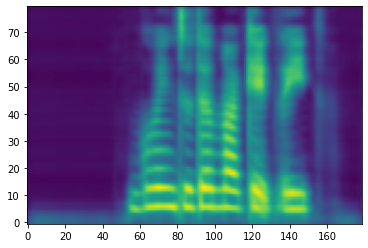

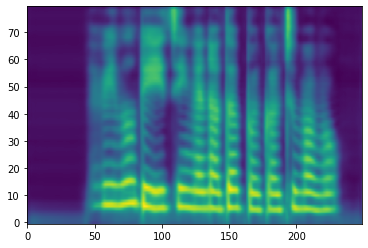

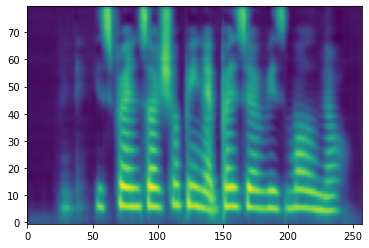

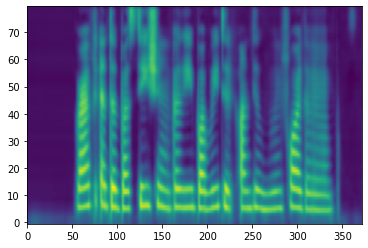

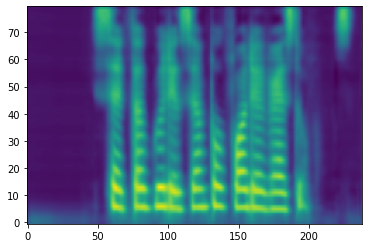

In [71]:
speaker_id = 178 ## TO BE CHANGED ## 
from pydub import AudioSegment
TTS_script_path = '/home/dgxuser/Desktop/kailin/TTS_script.txt'

mixing = False

last_ckpt = get_best_ckpt_from_last_run("./", speaker_id, mixing)
print(last_ckpt)

spec_model = FastPitchModel.load_from_checkpoint(last_ckpt)
spec_model.eval().cuda()

lines = []
with open(TTS_script_path, "r") as f:
    line = f.readline()
    while line != '':
        lines.append(line)
        line = f.readline()
            
for i, line in enumerate(lines):
    spec, audio = infer(spec_model, vocoder, line)
    ipd.display(ipd.Audio(audio, rate=22050))
    audio = ipd.Audio(audio, rate=22050)
    audio = AudioSegment(audio.data) 
    filename = 'S' + str(speaker_id) + '_LINE' + str(i) + '.wav'
    audio.export(filename, format="wav")
    %matplotlib inline
    imshow(spec, origin="lower", aspect="auto")
    plt.show()